<a href="https://colab.research.google.com/github/andrea-mar/MSci-Project/blob/main/subreddits_text_classification_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

code reference: https://www.youtube.com/watch?v=vNKIg8rXK6w&t=1492s&ab_channel=rupertai

In [1]:
!nvidia-smi

Thu Oct 12 10:57:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive

In [3]:
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_data_path = '/content/drive/MyDrive/MS_DS_NLP_project/asd_subs_data_annotated/train_data.csv'
test_data_path = '/content/drive/MyDrive/MS_DS_NLP_project/asd_subs_data_annotated/test_data.csv'

In [5]:
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [6]:
train_data.head(3)

,Unnamed: 0,text,Other,ASD
0,116,womenonthespectrum womenonthespectrum A commun...,0,1
1,293,The Owl House The Owl House A subreddit for th...,1,0
2,452,Autism Speaks Sucks Autism Speaks Sucks A comm...,0,1


In [7]:
# dataset is relatively ballanced
train_data['ASD'].value_counts()

1    90
0    78
Name: ASD, dtype: int64

In [8]:
len(train_data)

168

In [9]:
test_data.head(3)

,Unnamed: 0,text,Other,ASD
0,231,Gamingcirclejerk Gaming Circlejerk Don Cheadle...,1,0
1,243,ASDpeersupport ASD Peer Support Peer based sup...,0,1
2,392,selfharm A Subreddit for Self Harmers A subred...,1,0


In [10]:
# dataset is relatively balanced
test_data['ASD'].value_counts()

1    23
0    19
Name: ASD, dtype: int64

DEEP LEARNING LLMs - RoBERTa-large huggingface

In [11]:
%%capture
%pip install transformers
%pip install pytorch-lightning

Pipeline

model to fine tune : RoBERTa. - due to comutational limitations the smaller version will be used (distiledroberta).

original article : https://arxiv.org/abs/1907.11692

huggingface:
RoBERTa: https://huggingface.co/roberta-base
distilroberta: https://huggingface.co/distilroberta-base

roberta-base is case sensitive
The datasets have no stop words (droped in the data cleaning stage) - even if there is a loss of useful context in the case of RoBERTa, it was done with a perspective of having a maximum of important words within the limit of the RoBERTa maximum sequence length, which is 512 tokens. (same as this article https://hal.science/hal-03725602)




<Axes: >

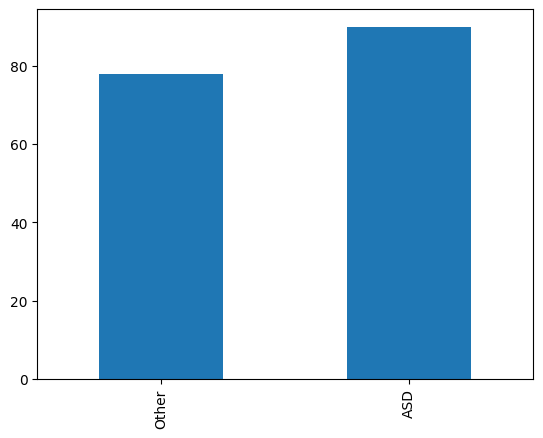

In [12]:
attributes = ['Other', 'ASD']
train_data[attributes].sum().plot.bar()

<Axes: >

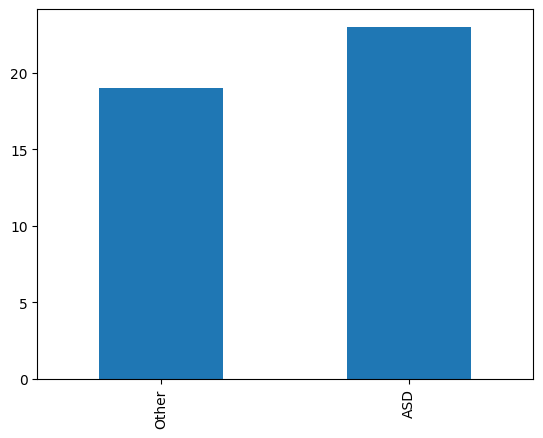

In [13]:
test_data[attributes].sum().plot.bar()

In [14]:
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaForSequenceClassification, RobertaTokenizer

from sklearn.model_selection import train_test_split

In [15]:
# create a pytorch Dataset object containing tokenized and vectorized data
class Suberddits_Dataset(Dataset):
  np.random.seed(7)

  def __init__(self, data, tokenizer, attributes, max_token_len: int=512):
    self.data = data # dataframe (pandas)
    self.tokenizer = tokenizer
    self.attributes = attributes # class labels : ASD and Other
    self.max_token_len = max_token_len # 512 is the max RoBERTa accepts (see above)

  def __len__(self):
    return(len(self.data))


  def __getitem__(self, index):
    item = self.data.iloc[index] # get the item in the df at the given index
    text = str(item.text) # get the text for that row
    attr = torch.FloatTensor(item[self.attributes]) # get the values for ASD and Other cols in a tensor format
    # tokenize the text (as PyTorch tensors)
    tokens = self.tokenizer.encode_plus(text,
                                        return_tensors='pt', # return pytorch tensors
                                        truncation=True, # truncate the longer text
                                        max_length=self.max_token_len, # truncate the text to a max length of 512
                                        padding='max_length', # apply a padding to all text that is shorter that the max length (512)
                                        return_attention_mask=True)
    return {
        'input_ids': tokens.input_ids.flatten(),
        'attention_mask': tokens.attention_mask.flatten(),
        'labels': attr
        }


In [16]:
model_name = 'distilroberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [17]:
attributes = ['Other', 'ASD']
train_dataset = Suberddits_Dataset(train_data, tokenizer, attributes)
test_dataset = Suberddits_Dataset(test_data, tokenizer, attributes)

In [18]:
# what the item (text representation  and labels) looks like as PyTorch tensors
train_dataset.__getitem__(30)

{'input_ids': tensor([    0, 25683,   293, 20207,   293,     5,  1461,   187,  2266, 20207,
           293,    83,   169,     9,  9072,  4106,   335,   145,  1373,   660,
          7510,     9,    10,  2040,    50,   467,     9,  3650,    14,   189,
            28,  1687,     7,    28,  1595,    31,    65,  1736,     7,   277,
            30,   295,  1657,   225, 15557,   839,   941, 40059,   475, 43237,
            21,   259, 14826,     7, 20207,   293,  2573, 12555,    30,  1717,
          1577,  1178,   274,   134,  4629,  1178,  1577,  8515,     9,    10,
         25426, 26012, 32148,    10,   169,     9,  9072,  4106,   335,   145,
          1373,    41,  7510,     9,    10,  2040,    50,   467,     9,  3650,
            14,   189,    28,  1687,     7,    28,  1595,    31,    65,  1736,
             7,   277,    30,   295,  1657,   225, 15557,   839,   941, 40059,
          3401,  1591, 38451,  3629,  6114,     5,   235,     7,  3438,   143,
           618,    13,   143,  1219, 20

In [19]:
len(train_dataset), len(test_dataset)

(168, 42)

In [20]:
train_dataset.data.head(3)

,Unnamed: 0,text,Other,ASD
0,116,womenonthespectrum womenonthespectrum A commun...,0,1
1,293,The Owl House The Owl House A subreddit for th...,1,0
2,452,Autism Speaks Sucks Autism Speaks Sucks A comm...,0,1


In [21]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold

In [22]:
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from pytorch_lightning import LightningDataModule
from typing import Optional

class Suberddits_Data_Module(LightningDataModule):
    def __init__(
        self,
        train_df,
        test_df,
        attributes,
        model_name="roberta-base",  # default model name if not provided
        k: int = 1,  # fold number
        num_splits: int = 10,
        split_seed = 7, # split the folds consistently the same each time code runs
        batch_size: int = 32,
        num_workers: int = 2,
        pin_memory: bool = False,
    ):
        super().__init__()

        # save hyperparameters ( this allows use of self.hparams.<hparam>)
        self.save_hyperparameters()
        self.train_df = train_df
        self.test_df = test_df
        self.attributes = attributes

        # initialize the tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(self.hparams.model_name)

        # data transformations
        self.transforms = None

        # Initialize datasets as None
        self.data_train = None
        self.data_val = None
        self.data_test = None

    def setup(self, stage=None):
        if not self.data_train and not self.data_val:
            # split the training data into k folds for training and validation
            kf = KFold(n_splits=self.hparams.num_splits, shuffle=True, random_state=self.hparams.split_seed)
            all_splits = [k for k in kf.split(self.train_df)]
            train_indexes, val_indexes = all_splits[self.hparams.k]
            train_indexes, val_indexes = train_indexes.tolist(), val_indexes.tolist()

            # create training and validation datasets
            self.data_train = Suberddits_Dataset(self.train_df.iloc[train_indexes], self.tokenizer, self.attributes)
            self.data_val = Suberddits_Dataset(self.train_df.iloc[val_indexes], self.tokenizer, self.attributes)

        if stage == 'predict':
            self.data_test = Suberddits_Dataset(self.test_df, self.tokenizer, self.attributes)

    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
        )

    def predict_dataloader(self):
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
        )

In [23]:
train_module = Suberddits_Data_Module(train_data, test_data, attributes)

In [24]:
train_module.setup()

In [25]:
dl = train_module.train_dataloader()

In [26]:
len(dl)

5

Model

In [27]:
from transformers import AutoModel, get_cosine_schedule_with_warmup
from torch.optim import AdamW
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc
import torch.nn.functional as F

In [28]:
class Subreddits_Classifier(pl.LightningModule):
  def __init__(self, config: dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict=True)
    self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    self.classifier = nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
    torch.nn.init.xavier_uniform(self.hidden.weight)
    torch.nn.init.xavier_uniform(self.classifier.weight)
    self.loss_function = nn.BCEWithLogitsLoss(reduction='mean')
    self.dropout = nn.Dropout()


  def forward(self, input_ids, attention_mask, labels=None):
    # distiled roberta model
    output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = torch.mean(output.last_hidden_state, 1)
    # nn classification layers
    pooled_output = self.hidden(pooled_output)
    pooled_output = self.dropout(pooled_output)
    pooled_output = F.relu(pooled_output)
    logits = self.classifier(pooled_output)
    # compute the loss
    loss = 0
    if labels is not None:
      loss = self.loss_function(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
    return loss, logits

  def training_step(self, batch, batch_index):
    loss, logits = self(**batch)
    self.log('train_loss', loss, prog_bar=True, logger=True)
    return {'loss': loss, 'predictions': logits, 'labels': batch['labels']}

  def validation_step(self, batch, batch_index):
    loss, logits = self(**batch)
    self.log('validation loss', loss, prog_bar=True, logger=True)
    return {'val_loss': loss, 'predictions': logits, 'labels': batch['labels']}

  def predict_step(self, batch, batch_index):
    _, logits = self(**batch)
    return logits

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['w_decay'])
    total_steps = self.config['train_size'] / self.config['batch_size']
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    return [optimizer], [scheduler]

Train

In [29]:
config = {
    'model_name': 'distilroberta-base',
    'n_labels': len(attributes),
    'batch_size': 14,
    'lr': 1.5e-6,
    'warmup': 0.2,
    'train_size': len(train_module.train_dataloader()),
    'w_decay': 0.001,
    'n_epoch': 100
}

In [30]:
np.random.seed(7)
model = Subreddits_Classifier(config)

<ipython-input-28-63670cb1b610>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.hidden.weight)
<ipython-input-28-63670cb1b610>:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.classifier.weight)


In [31]:
idx = 0
input_ids = train_dataset.__getitem__(idx)['input_ids']
att_mask = train_dataset.__getitem__(idx)['attention_mask']
labels = train_dataset.__getitem__(idx)['labels']

In [32]:
loss, output = model(input_ids.unsqueeze(dim=0), att_mask.unsqueeze(dim=0), labels.unsqueeze(dim=0))

In [33]:
loss, output

(tensor(0.6774, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 tensor([[0.3313, 0.4781]], grad_fn=<AddmmBackward0>))

Train

In [34]:
from pytorch_lightning.callbacks import EarlyStopping

# prevent overfitting
# early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='validation loss',  # metric to monitor
    min_delta=0.001,  # min change in validation loss to be considered an improvement
    patience=10,  # Nnumber of epochs with no improvement before stopping
    verbose=True,
    mode='min'  # 'min' because we want to minimize loss
)

In [35]:
import random
seed = 7

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

random.seed(seed)
np.random.seed(seed)

# train module
train_module = Suberddits_Data_Module(train_data, test_data, attributes, batch_size=config['batch_size'])
train_module.setup()

# model
model = Subreddits_Classifier(config)

# train
trainer = pl.Trainer(
    max_epochs=config['n_epoch'],
    num_sanity_val_steps=2,
    callbacks=[early_stopping_callback]
    )

trainer.fit(model, train_module)

<ipython-input-28-63670cb1b610>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.hidden.weight)
<ipython-input-28-63670cb1b610>:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.classifier.weight)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type              | Params
-------------------------------------------------------
0 | pretrained_model | RobertaModel      | 82.1 M
1 | hidden           | Linear  

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved. New best score: 0.667


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.014 >= min_delta = 0.001. New best score: 0.653


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.014 >= min_delta = 0.001. New best score: 0.639


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.013 >= min_delta = 0.001. New best score: 0.626


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.015 >= min_delta = 0.001. New best score: 0.611


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.017 >= min_delta = 0.001. New best score: 0.594


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.018 >= min_delta = 0.001. New best score: 0.577


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.018 >= min_delta = 0.001. New best score: 0.559


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.020 >= min_delta = 0.001. New best score: 0.539


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.023 >= min_delta = 0.001. New best score: 0.516


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.015 >= min_delta = 0.001. New best score: 0.501


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.009 >= min_delta = 0.001. New best score: 0.492


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.005 >= min_delta = 0.001. New best score: 0.487


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.006 >= min_delta = 0.001. New best score: 0.482


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.004 >= min_delta = 0.001. New best score: 0.478


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.005 >= min_delta = 0.001. New best score: 0.473


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.008 >= min_delta = 0.001. New best score: 0.465


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.004 >= min_delta = 0.001. New best score: 0.461


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.012 >= min_delta = 0.001. New best score: 0.449


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.022 >= min_delta = 0.001. New best score: 0.427


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.012 >= min_delta = 0.001. New best score: 0.415


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.002 >= min_delta = 0.001. New best score: 0.412


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.024 >= min_delta = 0.001. New best score: 0.388


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.018 >= min_delta = 0.001. New best score: 0.370


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.018 >= min_delta = 0.001. New best score: 0.352


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.022 >= min_delta = 0.001. New best score: 0.330


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.013 >= min_delta = 0.001. New best score: 0.316


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.023 >= min_delta = 0.001. New best score: 0.293


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.012 >= min_delta = 0.001. New best score: 0.281


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.004 >= min_delta = 0.001. New best score: 0.277


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.020 >= min_delta = 0.001. New best score: 0.257


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.015 >= min_delta = 0.001. New best score: 0.243


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.012 >= min_delta = 0.001. New best score: 0.231


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.013 >= min_delta = 0.001. New best score: 0.218


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.015 >= min_delta = 0.001. New best score: 0.203


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss improved by 0.002 >= min_delta = 0.001. New best score: 0.200


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric validation loss did not improve in the last 10 records. Best score: 0.200. Signaling Trainer to stop.


In [36]:
%load_ext tensorboard

In [37]:
%tensorboard --logdir '/content/lightning_logs/version_0'

<IPython.core.display.Javascript object>

In [38]:
!ls -l

total 12
drwx------ 5 root root 4096 Oct 12 10:57 drive
drwxr-xr-x 3 root root 4096 Oct 12 10:58 lightning_logs
drwxr-xr-x 1 root root 4096 Oct 10 13:28 sample_data


In [39]:
!lsof -i :6006


COMMAND    PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
tensorboa 8596 root   14u  IPv4 559669      0t0  TCP localhost:6006 (LISTEN)


In [40]:
!kill 8563

/bin/bash: line 1: kill: (8563) - No such process


In [41]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir /content/lightning_logs/version_0 (started 0:00:00 ago; pid 8596)


In [42]:
notebook.display(port=6006, height=500)

Selecting TensorBoard with logdir /content/lightning_logs/version_0 (started 0:00:00 ago; port 6006, pid 8596).


<IPython.core.display.Javascript object>

In [43]:
!tensorboard dev upload \
  --logdir '/content/lightning_logs/version_0' \
  --name 'ditilroberta finetuned' \
  --description 'ditilroberta finetuned to ASD subreddits data' \
  --one_shot

2023-10-12 11:20:11.696265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/lightning_logs/version_0

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   BPBT-KZHD



**************************************************************

Predict with model

In [44]:
# method to convert list of text into predictions for each text
def classify_raw_text(model, dm):
  predictions = trainer.predict(model, dm)
  flatten_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])
  return flatten_predictions


In [45]:
predictions = classify_raw_text(model, train_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

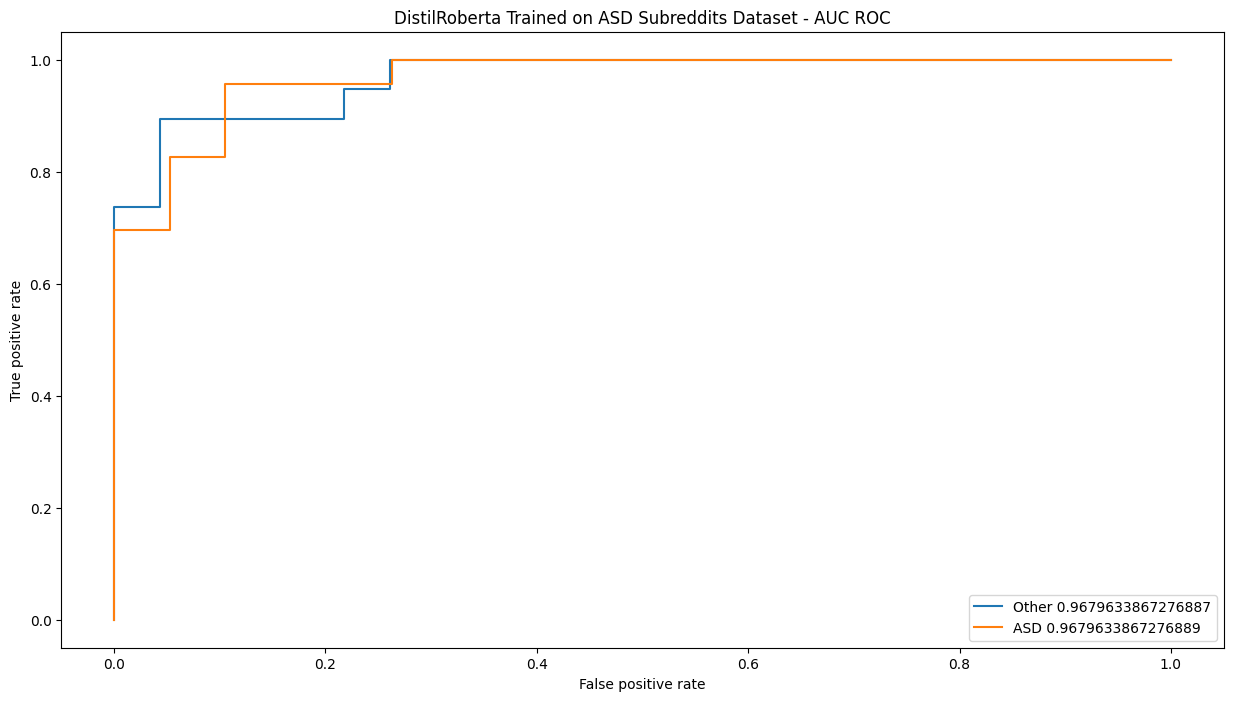

In [46]:
test_data_labels = np.array(test_data[attributes])

from sklearn import metrics

plt.figure(figsize=(15,8))
for i, attribute in enumerate(attributes):
  fpr, tpr, _ = metrics.roc_curve(
      test_data_labels[:,i].astype(int), predictions[:,i]
  )
  auc = metrics.roc_auc_score(
      test_data_labels[:,i].astype(int), predictions[:,i]
  )
  plt.plot(fpr, tpr, label=f'{attribute} {auc}')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.legend(loc='lower right')
  plt.title('DistilRoberta Trained on ASD Subreddits Dataset - AUC ROC')

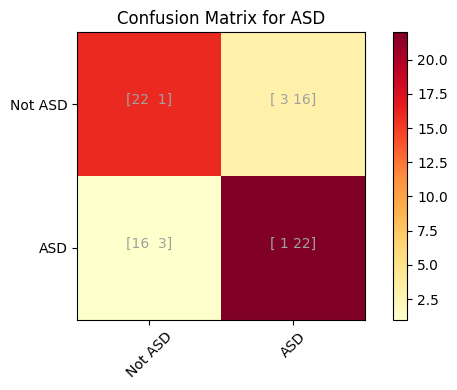

In [47]:
from sklearn.metrics import multilabel_confusion_matrix

# change predictions to binary labels (0 or 1)
binary_predictions = predictions.round()
conf_mtrx = multilabel_confusion_matrix(test_data_labels, binary_predictions)

# class labels
class_labels = ['Not ' + attribute, attribute]

# plot the confusion matrix
plt.figure(figsize=(6, 4))
plt.imshow(conf_mtrx[1], interpolation='nearest', cmap=plt.cm.YlOrRd)
plt.title(f'Confusion Matrix for {attributes[1]}')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

for i in range(2):
    for j in range(2):
      text_color = '#a1a1a1'
      plt.text(j, i, str(conf_mtrx[i][j]), horizontalalignment="center", color=text_color)

plt.tight_layout()
plt.show()


In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

# round predictions to convert probabilities to binary values (0 or 1)
rounded_predictions = predictions.round()

# accuracy score
accuracy = accuracy_score(test_data_labels, rounded_predictions)

# precision, recall, and F1 score
precisions = precision_score(test_data_labels, rounded_predictions, average=None)
recalls = recall_score(test_data_labels, rounded_predictions, average=None)
f1_scores = f1_score(test_data_labels, rounded_predictions, average=None)
f2_scores = fbeta_score(test_data_labels, rounded_predictions, beta=2, average=None)

print(f"Accuracy:   {accuracy:.4f}")
print(f"Precision:  Other: {precisions[0]:.4f}  |  ASD: {precisions[1]:.4f}  |  Avg: {(precisions[0] + precisions[1])/2:.4f}")
print(f"Recall:     Other: {recalls[0]:.4f}  |  ASD: {recalls[1]:.4f}  |  Avg: {(recalls[0] + recalls[1])/2:.4f}")
print(f"F1 Score:   Other: {f1_scores[0]:.4f}  |  ASD: {f1_scores[1]:.4f}  |  Avg: {(f1_scores[0] + f1_scores[1])/2:.4f}")
print(f"F2 Score:   Other: {f2_scores[0]:.4f}  |  ASD: {f2_scores[1]:.4f}  |  Avg: {(f2_scores[0] + f2_scores[1])/2:.4f}")



Accuracy:   0.9048
Precision:  Other: 0.9412  |  ASD: 0.8800  |  Avg: 0.9106
Recall:     Other: 0.8421  |  ASD: 0.9565  |  Avg: 0.8993
F1 Score:   Other: 0.8889  |  ASD: 0.9167  |  Avg: 0.9028
F2 Score:   Other: 0.8602  |  ASD: 0.9402  |  Avg: 0.9002


In [49]:
# the finetuned distilroberta model ( using subreddits data )
print(model)

Subreddits_Classifier(
  (pretrained_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La